In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# 指定.pkl文件的路径
file_path = "./R_ET_1_0.pkl"

# 打开并读取.pkl文件中的数据
with open(file_path, 'rb') as f:
    [SNR, FM, wholeFM, SNRw] = pickle.load(f)

# 提取 9x9 的 Fisher 矩阵，并仅保留前 7 个参数的子矩阵
def extract_relevant_submatrix(matrix, size=7):
    """提取前 size 个参数的子矩阵"""
    return matrix[:size, :size]

fisher_matrix_1 = extract_relevant_submatrix(FM)

print(fisher_matrix_1)

[[ 6.25162357e+02  5.50588656e+03  4.95517563e+05  1.59372497e+03
  -6.30320337e+02 -6.58566336e+05 -3.91101952e+02]
 [ 5.50588656e+03  1.25797291e+05  1.14203147e+07  2.04696721e+02
   1.39120379e+03 -3.99264456e+07 -8.73721741e+03]
 [ 4.95517563e+05  1.14203147e+07  1.03698696e+09  6.39836649e+02
   1.34072920e+05 -3.58463400e+09 -7.92854858e+05]
 [ 1.59372497e+03  2.04696721e+02  6.39836649e+02  6.62828596e+03
  -2.84814829e+03 -7.40254013e+03 -2.88889625e+02]
 [-6.30320337e+02  1.39120379e+03  1.34072920e+05 -2.84814829e+03
   1.25901745e+03 -2.47882681e+06 -8.34020492e+01]
 [-6.58566336e+05 -3.99264456e+07 -3.58463400e+09 -7.40254013e+03
  -2.47882681e+06  3.76758877e+11  1.47345779e+07]
 [-3.91101952e+02 -8.73721741e+03 -7.92854858e+05 -2.88889625e+02
  -8.34020492e+01  1.47345779e+07  1.23944815e+03]]


In [2]:
# 指定.pkl文件的路径
file_path = "./R_ET_2_0.pkl"

# 打开并读取.pkl文件中的数据
with open(file_path, 'rb') as f:
    [SNR, FM, wholeFM, SNRw] = pickle.load(f)

# 提取 9x9 的 Fisher 矩阵，并仅保留前 7 个参数的子矩阵
def extract_relevant_submatrix(matrix, size=7):
    """提取前 size 个参数的子矩阵"""
    return matrix[:size, :size]

fisher_matrix_2 = extract_relevant_submatrix(FM)

print(fisher_matrix_2)

[[ 7.04889104e+02  3.83210915e+03  4.16671716e+05 -1.70010064e+03
  -9.10510532e+02 -3.89619537e+05  4.39438430e+02]
 [ 3.83210915e+03  1.09653058e+05  9.84620778e+06  2.56776730e+03
   2.91769957e+03 -3.47029700e+07  9.82933138e+03]
 [ 4.16671716e+05  9.84620778e+06  8.93588681e+08  5.83301204e+02
   1.33330583e+05 -3.10804759e+09  9.04640633e+05]
 [-1.70010064e+03  2.56776730e+03  5.83301204e+02  5.73130357e+03
   3.24137321e+03 -6.70079438e+03 -3.10432162e+02]
 [-9.10510532e+02  2.91769957e+03  1.33330583e+05  3.24137321e+03
   1.87305443e+03 -2.46106977e+06  9.48538336e+01]
 [-3.89619537e+05 -3.47029700e+07 -3.10804759e+09 -6.70079438e+03
  -2.46106977e+06  3.29279258e+11 -1.66555844e+07]
 [ 4.39438430e+02  9.82933138e+03  9.04640633e+05 -3.10432162e+02
   9.48538336e+01 -1.66555844e+07  1.85450516e+03]]


In [3]:
# 指定.pkl文件的路径
file_path = "./R_ET_3_0.pkl"

# 打开并读取.pkl文件中的数据
with open(file_path, 'rb') as f:
    [SNR, FM, wholeFM, SNRw] = pickle.load(f)

# 提取 9x9 的 Fisher 矩阵，并仅保留前 7 个参数的子矩阵
def extract_relevant_submatrix(matrix, size=7):
    """提取前 size 个参数的子矩阵"""
    return matrix[:size, :size]

fisher_matrix_3 = extract_relevant_submatrix(FM)

print(fisher_matrix_3)

[[ 1.71097482e+03 -2.01574273e+03 -6.53431125e+04  2.41872229e+02
  -3.23282821e+03  1.29717641e+06 -6.89603632e+01]
 [-2.01574273e+03  3.53993636e+03  1.77150424e+05 -1.71567840e+02
   3.91288660e+03 -1.44958229e+06 -1.49652191e+03]
 [-6.53431125e+04  1.77150424e+05  1.11239413e+07  3.65512731e+00
   1.32416748e+05 -3.70691826e+07 -1.26772612e+05]
 [ 2.41872229e+02 -1.71567840e+02  3.65512731e+00  6.96489314e+01
  -4.46673580e+02 -5.18076640e+01 -4.74031233e+02]
 [-3.23282821e+03  3.91288660e+03  1.32416748e+05 -4.46673580e+02
   6.11764085e+03 -2.44623778e+06 -1.31962575e+01]
 [ 1.29717641e+06 -1.44958229e+06 -3.70691826e+07 -5.18076640e+01
  -2.44623778e+06  3.71338138e+09  2.19779602e+06]
 [-6.89603632e+01 -1.49652191e+03 -1.26772612e+05 -4.74031233e+02
  -1.31962575e+01  2.19779602e+06  6.10459399e+03]]


In [4]:
def check_fisher_matrix(matrix, name):
    print(f"\n检查 {name}:")
    print(f"矩阵形状: {matrix.shape}")
    print(f"矩阵条件数: {np.linalg.cond(matrix)}")
    print(f"是否对称: {np.allclose(matrix, matrix.T)}")

# 检查每个 Fisher 矩阵
check_fisher_matrix(fisher_matrix_1, "Fisher 矩阵 1 (ET_1)")
check_fisher_matrix(fisher_matrix_2, "Fisher 矩阵 2 (ET_2)")
check_fisher_matrix(fisher_matrix_3, "Fisher 矩阵 3 (ET_3)")


检查 Fisher 矩阵 1 (ET_1):
矩阵形状: (7, 7)
矩阵条件数: 522418639086516.2
是否对称: True

检查 Fisher 矩阵 2 (ET_2):
矩阵形状: (7, 7)
矩阵条件数: 505464962238436.0
是否对称: True

检查 Fisher 矩阵 3 (ET_3):
矩阵形状: (7, 7)
矩阵条件数: 326103200513731.7
是否对称: True


In [5]:
#参数名列表（去掉 Injection Number 和 Initial Phase）
PARAM_NAMES = [
    "Ra", "Dec", "Mass1", "Mass2", 
    "Inclination", "Polarization", 
    "Luminosity Distance"
]

In [6]:
def get_dynamic_epsilon(matrix):
    """根据矩阵的条件数和特征值标准差，动态生成正则化参数 epsilon。"""
    cond_number = np.linalg.cond(matrix)
    eigvals = np.linalg.eigvals(matrix)
    eigval_std = np.std(eigvals)

    epsilon = (
        1e-2 if cond_number > 1e20 or eigval_std > 1e2 else
        1e-3 if cond_number > 1e16 or eigval_std > 1e1 else
        1e-4 if cond_number > 1e12 else
        1e-6
    )
    print(f"条件数: {cond_number}, 特征值标准差: {eigval_std}, 正则化参数: {epsilon}")
    return epsilon

In [7]:
def ensure_positive_definite(matrix):
    """确保矩阵为正定矩阵，并返回处理后的矩阵。"""
    eigvals, eigvecs = np.linalg.eigh(matrix)
    eigvals_clipped = np.clip(eigvals, 1e-8, None)  # 将特征值剪裁至最小值 1e-8
    return eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T

In [8]:
def regularize_matrix(matrix):
    """正则化 Fisher 矩阵，确保其对称且可逆。"""
    epsilon = get_dynamic_epsilon(matrix)
    matrix_sym = (matrix + matrix.T) / 2  # 确保矩阵对称
    return ensure_positive_definite(matrix_sym + epsilon * np.eye(matrix.shape[0]))

In [9]:
def compute_covariance(fisher_matrix):
    """根据 Fisher 矩阵计算协方差矩阵，只保留需要的参数部分。"""
    # 只提取我们关心的 7 个参数对应的子矩阵
    fisher_submatrix = fisher_matrix[:7, :7]
    reg_matrix = regularize_matrix(fisher_submatrix)
    covariance_matrix = np.linalg.pinv(reg_matrix)
    print(f"协方差矩阵:\n{covariance_matrix}")
    return covariance_matrix

def compute_uncertainties(cov_matrix):
    """从协方差矩阵中提取每个参数的不确定度。"""
    uncertainties = np.sqrt(np.diag(cov_matrix))
    print(f"不确定度: {uncertainties}")
    return uncertainties

In [10]:
# 初始化存储不确定度结果的字典
uncertainty_results = {}  # 这行非常关键，确保字典已定义

# 遍历每个 Fisher 矩阵并计算不确定度
for i, fisher_matrix in enumerate([fisher_matrix_1, fisher_matrix_2, fisher_matrix_3], start=1):
    print(f"\n处理 Fisher 矩阵 {i}...")
    
    # 计算协方差矩阵
    cov_matrix = compute_covariance(fisher_matrix)  # 删除多余参数
    
    # 计算不确定度
    uncertainties = np.sqrt(np.diag(cov_matrix))  # 提取对角线元素并计算不确定度
    
    # 将结果存入字典
    detector_name = f"ET_{i}"
    uncertainty_results[detector_name] = uncertainties

# 查看不确定度结果
print("\n不确定度结果:")
for detector, uncertainties in uncertainty_results.items():
    print(f"{detector}: {uncertainties}")


处理 Fisher 矩阵 1...
条件数: 522418639086516.2, 特征值标准差: 131792074413.2653, 正则化参数: 0.01
协方差矩阵:
[[ 6.98509890e+01 -3.37788472e+00 -1.19452075e-03 -6.89897133e-01
   3.72685401e+01  9.89387839e-06 -3.05254572e-01]
 [-3.37785221e+00  2.20407548e-01 -5.73345638e-04 -1.10228954e-02
  -1.89943304e+00 -2.54074962e-07 -6.27138296e-03]
 [-1.19488036e-03 -5.73327692e-04  7.00369293e-06  5.03993990e-04
   4.40208351e-04 -2.73640040e-09  2.41182692e-04]
 [-6.89922619e-01 -1.10213390e-02  5.03990842e-04  2.32103418e+00
   4.92258129e+00 -5.85100377e-07  9.06172536e-01]
 [ 3.72684843e+01 -1.89944768e+00  4.40401097e-04  4.92259544e+00
   3.19808848e+01  4.19535190e-06  1.90131879e+00]
 [ 9.89400629e-06 -2.54085752e-07 -2.73635165e-09 -5.85098042e-07
   4.19542803e-06  9.86512314e-12 -3.90853754e-07]
 [-3.05266634e-01 -6.27065650e-03  2.41181315e-04  9.06172544e-01
   1.90131212e+00 -3.90854899e-07  3.58349788e-01]]

处理 Fisher 矩阵 2...
条件数: 505464962238436.0, 特征值标准差: 115184011825.21594, 正则化参数: 0.01
协方差矩阵:
[

In [11]:
# 定义参数名
PARAM_NAMES = [
    "Ra", "Dec", "Mass1", "Mass2", 
    "Inclination", "Polarization", 
    "Luminosity Distance"
]

# 创建 DataFrame 存储不确定度
df = pd.DataFrame(uncertainty_results, index=PARAM_NAMES)
df.index.name = "Parameter"

# 打印 DataFrame 结果
print("\n不确定度结果 DataFrame:")
display(df)


不确定度结果 DataFrame:


,ET_1,ET_2,ET_3
Parameter,,,
Ra,8.357690,8.269724,8.723194
Dec,0.469476,0.484946,1.802893
Mass1,0.002646,0.002952,0.019566
Mass2,1.523494,1.855931,5.598040
Inclination,5.655164,5.745636,4.922674
Polarization,0.000003,0.000003,0.000037
Luminosity Distance,0.598623,0.475328,0.415466


In [12]:
# 保存结果为 CSV 文件
output_file = "fisher_uncertainties.csv"
df.to_csv(output_file)

print(f"结果已保存至 {output_file}")


结果已保存至 fisher_uncertainties.csv


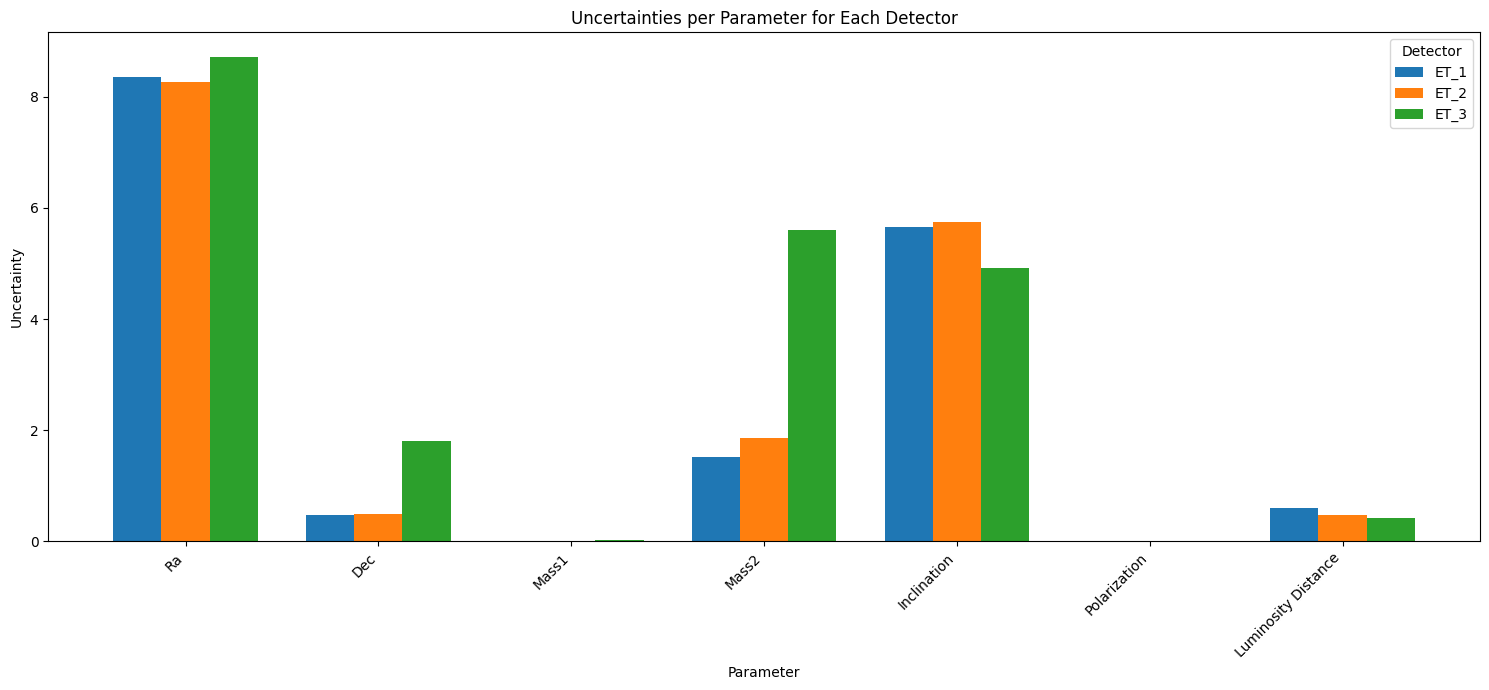

In [13]:
# 可视化不确定度结果
bar_width = 0.25
x = np.arange(len(PARAM_NAMES))

plt.figure(figsize=(15, 7))

# 绘制每个检测器的柱状图
for i, detector in enumerate(df.columns):
    plt.bar(x + i * bar_width, df[detector], width=bar_width, label=detector)

# 设置坐标轴和标题
plt.xticks(x + bar_width, PARAM_NAMES, rotation=45, ha='right')
plt.xlabel('Parameter')
plt.ylabel('Uncertainty')
plt.title('Uncertainties per Parameter for Each Detector')
plt.legend(title='Detector')

plt.tight_layout()
plt.show()